In [94]:
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

## Linear regression

#### Generate data

In [41]:
# Define the sample size and number of covariates
N = 5000
K = 3

# Generate the covariate matrix and the true effect sizes
X = np.hstack([np.ones((N, 1)), np.random.randn(N, K)])

beta_true = np.linspace(0.1, 0.4, K+1)

# Generate the phenotype
y = X.dot(beta_true) + np.random.randn(N)

Compute MLE for beta and sigma^2 and the log marginal likelihood of the model.

Parameters:
- y: observed data
- X: design matrix with covariates (without intercept)

Returns:
- beta_hat: MLE of beta
- sigma2_hat: MLE of sigma squared
- log_marginal_likelihood: log marginal likelihood of the model

In [42]:
def compute_MLE_and_LML(y, X):
    """
    Compute MLE for beta and sigma^2, standard errors for beta, 
    and the log marginal likelihood of the model.
    
    Parameters:
    - y: observed data
    - X: design matrix with covariates
    
    Returns:
    - beta_hat: MLE of beta
    - beta_se: Standard errors for beta
    - sigma2_hat: MLE of sigma squared
    - log_marginal_likelihood: log marginal likelihood of the model
    """
    
    # Compute MLE for beta using the closed-form solution
    beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    
    # Compute residuals
    residuals = y - X.dot(beta_hat)
    
    # Compute MLE for sigma squared (variance of the residuals)
    sigma2_hat = residuals.T.dot(residuals) / len(y)
    
    # Compute standard errors for beta_hat
    beta_se = np.sqrt(sigma2_hat * np.diag(np.linalg.inv(X.T.dot(X))))
    
    # Compute the log marginal likelihood of the model
    log_marginal_likelihood = np.sum(st.norm.logpdf(y, loc=X.dot(beta_hat), scale=np.sqrt(sigma2_hat)))
    
    return beta_hat, beta_se, sigma2_hat, log_marginal_likelihood

In [43]:
# Add a bias term (intercept) to X
beta_hat, beta_se, sigma2_hat, lml = compute_MLE_and_LML(y, X)

In [44]:
print(f"MLE of effect size (beta):", beta_hat)
print(f"Standard errors of effect size (beta_se):", beta_se)
print(f"MLE of residual variance (sigma2): {sigma2_hat:.4f}")
print(f"LML: {lml:.4f}")

MLE of effect size (beta): [0.11634087 0.21388185 0.29901934 0.39236173]
Standard errors of effect size (beta_se): [0.01423916 0.01439681 0.01416831 0.01405056]
MLE of residual variance (sigma2): 1.0137
LML: -7128.6637


* Plot Estimated vs True Beta with Standrd errors
* What happens if you increase sample size? $500\longrightarrow{1000}\longrightarrow{5000}$

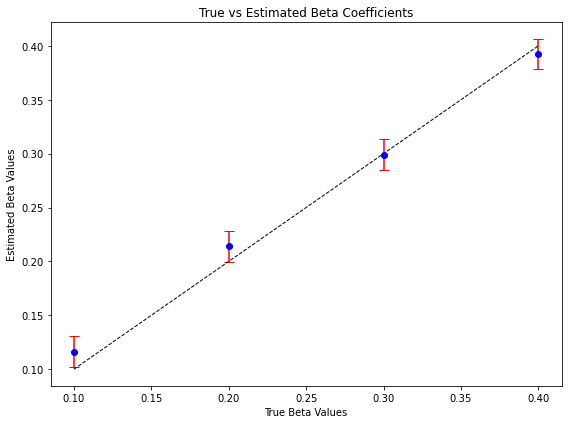

In [46]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.errorbar(beta_true, beta_hat, yerr=beta_se, fmt='o', color='blue', ecolor='red', capsize=5)
plt.plot([min(beta_true), max(beta_true)], [min(beta_true), max(beta_true)], 'k--', lw=1)  # Diagonal line for reference

plt.xlabel('True Beta Values')
plt.ylabel('Estimated Beta Values')
plt.title('True vs Estimated Beta Coefficients')
plt.tight_layout()

plt.show()

## Linear models for genetics

**Objectives:**
- **Given \(N=500\) samples:**
    1. Generate age, sex, and one genotype.
    2. Generate a phenotype as a linear function of age and sex (null model).
- **Build a lrt_test function:**
    1. Function should take as input: phenotype, covariates (age and sex), and genotype vector.
    2. Returns should include: effect size (beta), standard error (se), and p-value.

#### Generate data

In [52]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
N = 500

# Generate random age between 20 and 80
age = np.random.randint(20, 80, (N, 1))

# Generate random sex (0 = male, 1 = female)
sex = np.random.randint(0, 2, (N, 1))

# Generate random genotype (0, 1, or 2) using binomial with 2 trials and specified allele frequency
maf = 0.3 # minor allele frequency
genotype = np.random.binomial(2, p, (N, 1))

# Generate phenotype
variance_age = 0.10
variance_sex = 0.10
variance_genotype = 0.
variance_noise = 1 - variance_age - variance_sex - variance_genotype
phenotype = np.sqrt(variance_age) * StandardScaler().fit_transform(age)
phenotype+= np.sqrt(variance_sex) * StandardScaler().fit_transform(sex)
phenotype+= np.sqrt(variance_genotype) * StandardScaler().fit_transform(genotype)
phenotype+= np.sqrt(variance_noise) * np.random.normal(0, 1, (N, 1))

In [54]:
# final data
F = np.column_stack((np.ones(N), age, sex))
g = genotype
y = phenotype

In [61]:
def lrt_test(y, F, g):
    """
    Conducts a likelihood ratio test for a given genotype and set of covariates.
    
    Parameters:
    - y: observed data (phenotype)
    - F: design matrix for null model (covariates without genotype)
    - g: genotype data
    
    Returns:
    - beta_geno: Effect size of genotype under the alternative model
    - beta_se_geno: Standard error of the effect size of genotype under the alternative model
    - p_value: p-value from the likelihood ratio test
    """
    
    # Fit the null model (without genotype)
    _, _, _, loglik_null = compute_MLE_and_LML(y, F)
    
    # Add genotype to the covariates for the alternative model
    X_alt = np.column_stack((F, g))
    
    # Fit the alternative model (with genotype)
    beta_hat_alt, beta_se_alt, _, loglik_alt = compute_MLE_and_LML(y, X_alt)
    
    # Compute LRT statistic
    lrt_stat = -2 * (loglik_null - loglik_alt)
    
    # Compute p-value. Using 1 dof since we're testing for 1 additional parameter (genotype effect)
    p_value = 1 - st.chi2.cdf(lrt_stat, 1)
    
    # Effect size of genotype and its standard error from the alternative model
    beta_geno = beta_hat_alt[-1]  # Genotype effect is the last coefficient
    beta_se_geno = beta_se_alt[-1]
    
    return beta_geno[0], beta_se_geno[0], p_value

In [62]:
# Call the lrt_test function
beta_geno, beta_se_geno, p_value = lrt_test(y, F, g)
print(f"Effect size of genotype: {beta_geno:.4f}")
print(f"Standard error: {beta_se_geno:.4f}")
print(f"P-value: {p_value:.4f}")

Effect size of genotype: 0.0077
Standard error: 0.1293
P-value: 0.9363


## Assessing the Distribution of P-values Under the Null

To understand the behavior of our statistical test under the null hypothesis, we will simulate data where the true genetic effect is zero and evaluate the distribution of resulting p-values from the likelihood ratio test. This helps in verifying whether our test maintains the desired type I error rate.

### Steps:

1. **Loop Over Simulations**: 
   - We'll perform this process for 10,000 iterations to ensure a robust assessment of the p-value distribution.
   
2. **Generate a Random Genetic Variant**:
   - In each iteration, simulate a genetic variant to be tested.
   
3. **Simulate Phenotype Under the Null**:
   - Use the `simulate_phenotype` function to generate phenotypic values. Ensure the genetic variance (`variance_genotype`) is set to zero to simulate data under the null hypothesis.
   
4. **Perform the Likelihood Ratio Test**:
   - For each simulated dataset, apply the `lrt_test` function to obtain a p-value. This p-value indicates the significance of the genetic variant's association with the phenotype in the context of the given covariates.
   
5. **Collect and Analyze P-values**:
   - Store the p-values from each iteration in a list.
   - Plot a histogram to visualize the distribution of these p-values.
   - Create a QQ (quantile-quantile) plot to compare the distribution of our p-values to what we'd expect under the null hypothesis. A QQ plot helps in identifying systematic deviations from the expected uniform distribution of p-values under the null.

By the end of this analysis, we aim to validate that when there's truly no genetic effect, our test yields a uniform distribution of p-values, thereby maintaining the nominal type I error rate.


In [64]:
def simulate_phenotype(g, variance_genotype, N):
    """
    Simulates a phenotype based on a genetic variant.
    
    Parameters:
    - g: Genetic variant
    - variance_genotype: Variance explained by the genetic variant
    - N: Number of samples
    
    Returns:
    - phenotype: Simulated phenotype
    """
    
    # Ensure that g has the right shape
    if len(g.shape) == 1:
        g = g.reshape((N, 1))
    
    # Calculate variance due to noise
    variance_noise = 1 - variance_genotype
    
    # Generate phenotype
    phenotype = np.sqrt(variance_genotype) * StandardScaler().fit_transform(g)
    phenotype += np.sqrt(variance_noise) * np.random.normal(0, 1, (N, 1))
    
    return phenotype

In [66]:
# Parameters
N = 500
iterations = 10000
maf = 0.3

In [67]:
# Initializing list for p-values
p_values = []

# Progress loop
for _ in tqdm(range(iterations)):
    # Generate random genetic variant (0, 1, or 2)
    g = np.random.binomial(2, maf, (N, 1))
    
    # Simulate phenotype under the null
    y = simulate_phenotype(g, 0, N)
    
    # Generate random covariates (For simplicity, let's consider an intercept term only)
    F = np.ones((N, 1))
    
    # Perform the likelihood ratio test and store the p-value
    p_values.append(lrt_test(y, F, g)[-1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2344.17it/s]


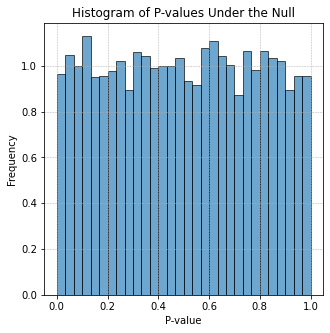

In [72]:
# Plot histogram of p-values
plt.figure(figsize=(5,5))
plt.hist(p_values, bins=30, edgecolor='k', alpha=0.65, density=True)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Histogram of P-values Under the Null')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [75]:
def qq_plot(ax, p_values):
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - figsize: size of the plot
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')

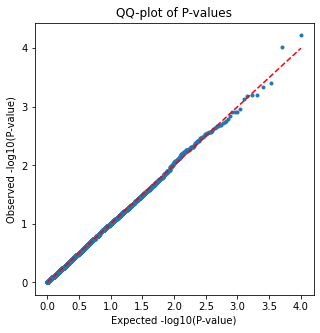

In [76]:
# QQ plot
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.title('QQ-plot of P-values')
qq_plot(ax, p_values)
plt.show()

## Simulating Data and Assessing Multiple Testing Corrections Under the Alternative Model

To investigate the behavior of our statistical tests under the alternative hypothesis, where a genetic variant has an effect on the phenotype, we'll simulate such scenarios. Further, we will apply multiple testing corrections and assess their impact.

### Steps:

1. **Loop Over Simulations**:
   - Iterate through a predefined number of simulations, e.g., 10,000 times, to generate robust results.
   
2. **Generate a Random Genetic Variant**:
   - In each loop, simulate a genetic variant.
   
3. **Simulate Phenotype Under the Alternative**:
   - Use the `simulate_phenotype` function. This time, set the `variance_genotype` to a non-zero value, representing a genuine genetic effect on the phenotype.
   
4. **Conduct Statistical Tests**:
   - Apply the `lrt_test` function on each dataset to get p-values, testing the association of the genetic variant with the phenotype.
   
5. **After getting all P values, Apply Multiple Testing Corrections**:
   
   a. **Bonferroni Correction**:
      - Adjust the p-values using Bonferroni correction.
      - Determine the number of significant tests at a given alpha, e.g., 0.05.
   
   b. **False Discovery Rate (FDR) Control**:
      - Use an FDR control method, like Benjamini-Hochberg, to adjust the p-values.
      - Identify the number of significant tests at a chosen q-value threshold, e.g., 0.05.
   
6. **Evaluate Test Power**:
   - Based on the true simulated effects and the test results, compute the power, representing the proportion of true positives out of all positives.
   
7. **Visualize Results**:
   
   a. **QQ Plots**:
      - Generate QQ plots for raw p-values and for those adjusted using each correction method.

By following these steps, we'll simulate data under the alternative hypothesis, apply multiple testing corrections, and evaluate their outcomes in the context of genetic studies.


In [80]:
# Parameters
N = 500
iterations = 10000
maf = 0.3
genotype_variance = 0.01

In [81]:
# Initializing list for p-values
p_values = []

# Progress loop
for _ in tqdm(range(iterations)):
    # Generate random genetic variant (0, 1, or 2)
    g = np.random.binomial(2, maf, (N, 1))
    
    # Simulate phenotype under the null
    y = simulate_phenotype(g, genotype_variance, N)
    
    # Generate random covariates (For simplicity, let's consider an intercept term only)
    F = np.ones((N, 1))
    
    # Perform the likelihood ratio test and store the p-value
    p_values.append(lrt_test(y, F, g)[-1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2338.91it/s]


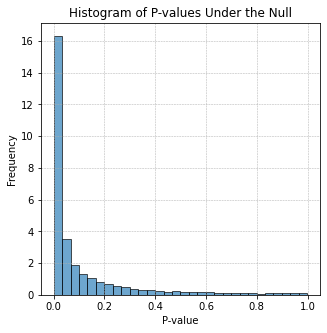

In [82]:
# Plot histogram of p-values
plt.figure(figsize=(5,5))
plt.hist(p_values, bins=30, edgecolor='k', alpha=0.65, density=True)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Histogram of P-values Under the Null')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

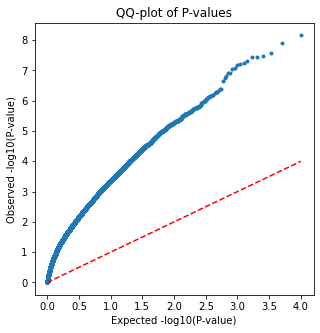

In [83]:
# QQ plot
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.title('QQ-plot of P-values')
qq_plot(ax, p_values)
plt.show()

In [87]:
alpha = 0.05

# Multiple testing corrections
rejected_bonferroni, pvals_bonferroni, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
rejected_fdr, pvals_fdr, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# Number of discoveries
num_discoveries_bonferroni = sum(rejected_bonferroni)
num_discoveries_fdr = sum(rejected_fdr)

# Results
print(f"Number of significant associations using Bonferroni correction: {num_discoveries_bonferroni}/{iterations} (power = {num_discoveries_bonferroni/iterations})")
print(f"Number of significant associations using FDR control: {num_discoveries_fdr}/{iterations} (power = {num_discoveries_fdr/iterations})")

Number of significant associations using Bonferroni correction: 96/10000 (power = 0.0096)
Number of significant associations using FDR control: 4967/10000 (power = 0.4967)


## Power Analysis

### Introduction

Power analysis allows us to determine the probability that a statistical test will detect an effect when there is an effect to be detected. In the context of genetic association studies, this means evaluating the likelihood of detecting a true association between a genetic variant and a phenotype. 

### Task 1: Defining the `compute_power` Function

**Function**: `compute_power`

**Description**:  
This function simulates datasets and calculates the power of a statistical test to detect an association between a genetic variant and a phenotype. It does this by comparing the p-values obtained from the tests to a significance threshold, after adjusting for multiple testing.

**Input**:  
- `N`: Sample size (e.g., 500)
- `maf`: Minor allele frequency, which defines the frequency of the less common allele (e.g., 0.1)
- `genotype_variance`: Variance explained by the genetic variant (e.g., 0.01)
- `iterations`: Number of simulations (e.g., 1000)

**Output**:
- `power_bonferroni`: Power after adjusting p-values using the Bonferroni correction.
- `power_fdr`: Power after adjusting p-values using the False Discovery Rate (FDR) method.

### Task 2: Power Assessment

Using the `compute_power` function, you'll assess the statistical power as a function of:

1. **Sample Size**:
   - Default values to start: `N = [200, 500, 1000, 2000]`
   - Keep `maf` and `genotype_variance` constant.

2. **Allele Frequency**:
   - Default values to start: `maf = [0.05, 0.1, 0.2, 0.3]`
   - Keep `N` and `genotype_variance` constant.

3. **Genotype Variance**:
   - Default values to start: `genotype_variance = [0.005, 0.01, 0.02, 0.05]`
   - Keep `N` and `maf` constant.

For each parameter set in the above scenarios, loop through its values, use the `compute_power` function, and visualize the power using bar plots. This will allow you to see how power changes as a function of sample size, allele frequency, and genotype variance.


In [ ]:
def compute_power(N, maf, genotype_variance, iterations):
    # Simulate phenotypes and genotypes for the specified number of iterations
    p_values = []
    for _ in range(iterations):
        genotype = np.random.binomial(2, maf, (N, 1))
        phenotype = simulate_phenotype(genotype, genotype_variance, N)
        F = np.ones((N, 1))
        pval = lrt_test(phenotype, F, genotype)[-1]
        p_values.append(pval)

    # Apply multiple testing corrections
    rejected_bonferroni, _, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')
    rejected_fdr, _, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

    # Compute power for each correction method
    power_bonferroni = sum(rejected_bonferroni) / iterations
    power_fdr = sum(rejected_fdr) / iterations

    return power_bonferroni, power_fdr